# Extractive summarization of speeches

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank'
import os
os.chdir(root_path)
retval = os.getcwd()
print("Current working directory %s" % retval)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current working directory /content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank


In [0]:
import pandas as pd
import numpy as np

In [4]:
!gdown --id 1J7h0H8HsqqcLlbM0zUZGGCn2jh3ZnpgD # parsed data
speech_df = pd.read_csv('parsed.csv')
speech_df= speech_df.dropna(subset = ['transcript']).reset_index(drop = True)
speech_df.info()

df = speech_df.copy()

# for reading larger csv files
# chunksize = 10 ** 8
#for chunk in pd.read_csv('parsed.csv', chunksize=chunksize):
#  print(chunk.head(5))

Downloading...
From: https://drive.google.com/uc?id=1J7h0H8HsqqcLlbM0zUZGGCn2jh3ZnpgD
To: /content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/parsed.csv
16.6MB [00:00, 77.3MB/s]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       1202 non-null   object
 1   speaker     1202 non-null   object
 2   transcript  1202 non-null   object
 3   year        1202 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 37.7+ KB


## NLTK library and text summarization using word frequency

In [5]:
import nltk
import string # import string for list of punctuations
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
speech_df_copy= speech_df.dropna(subset = ['transcript']).reset_index(drop = True)
speech_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       1202 non-null   object
 1   speaker     1202 non-null   object
 2   transcript  1202 non-null   object
 3   year        1202 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 37.7+ KB


In [7]:
# Tokenize the transcript
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+')
speech_df['transcript'] = speech_df['transcript'].apply(lambda x: tokenizer.tokenize(x.lower()) if type(x) == str else False)
speech_df['transcript'].head(2)

0    [this, is, one, of, the, most, moving, days, o...
1    [in, the, spring, of, 1987, president, reagan,...
Name: transcript, dtype: object

Text summarization based on word frequencies

In [0]:
# Used an existing text summarization method -- word frequency summarization. Will modify.
# https://github.com/akashp1712/nlp-akash/blob/master/text-summarization/Word_Frequency_Summarization.py

def create_frequency_table(text_string) -> dict:

    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text_string)
    ps = PorterStemmer()

    freqTable = dict()
    for word in words:
        word = ps.stem(word)
        if word in stopWords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    return freqTable


def score_sentences(sentences, freqTable) -> dict:

    sentenceValue = dict()

    for sentence in sentences:
        word_count_in_sentence = (len(word_tokenize(sentence)))
        word_count_in_sentence_except_stop_words = 0
        for wordValue in freqTable:
            if wordValue in sentence.lower():
                word_count_in_sentence_except_stop_words += 1
                if sentence[:10] in sentenceValue:
                    sentenceValue[sentence[:10]] += freqTable[wordValue]
                else:
                    sentenceValue[sentence[:10]] = freqTable[wordValue]

        if sentence[:10] in sentenceValue:
            sentenceValue[sentence[:10]] = sentenceValue[sentence[:10]] / word_count_in_sentence_except_stop_words

        '''
        Notice that a potential issue with our score algorithm is that long sentences will have an advantage over short sentences. 
        To solve this, we're dividing every sentence score by the number of words in the sentence.
        
        Note that here sentence[:10] is the first 10 character of any sentence, this is to save memory while saving keys of
        the dictionary.
        '''

    return sentenceValue


def find_average_score(sentenceValue) -> int:
    """
    Find the average score from the sentence value dictionary
    :rtype: int
    """
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original text
    average = (sumValues / len(sentenceValue))

    return average


def generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:10] in sentenceValue and sentenceValue[sentence[:10]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1
    
    return summary


In [0]:
def run_summarization(i, text, gamma):
    # 1 Create the word frequency table
    freq_table = create_frequency_table(text)

    # 2 Tokenize the sentences
    sentences = sent_tokenize(text)

    # 3 Important Algorithm: score the sentences
    sentence_scores = score_sentences(sentences, freq_table)

    # 4 Find the threshold
    threshold = find_average_score(sentence_scores)

    # 5 Important Algorithm: Generate the summary
    summary = generate_summary(sentences, sentence_scores, gamma * threshold)
    summary_length = len(summary.split())
    original_length = len(text.split())
    ratio = summary_length/original_length
    print('#', i, 'gamma', gamma, 'summary length:', summary_length, 'original length:', original_length, 'extraction ratio:', ratio, '\n', summary)
    return summary, summary_length

In [13]:
test = speech_df_copy['transcript'][4]
summarized_test = run_summarization(0, test, np.floor(len(test.split())/1000)/10 + 1.3)

# 0 gamma 1.6 summary length: 101 original length: 3379 extraction ratio: 0.029890500147972773 
  In short, the Constitution is not buried in the mists of time. We know who did what, when, and many times why. But to begin, it may be useful to say what it is not. The plain fact is, it exists. They proposed, they substituted, they edited, and they carefully revised. It speaks volumes on how problems should be approached, and by whom. It is a jurisprudence that cares about committing and limiting to each organ of government the proper ambit of its responsibilities. It is a jurisprudence faithful to our Constitution. Out of such arguments come no losers, only truth.


In [22]:
for i, text in enumerate(speech_df_copy.transcript):
   original_length = len(speech_df_copy['transcript'][i].split())
   gamma = np.floor(original_length/1000)/10 + 1.2
   summary, length = run_summarization(i, speech_df_copy['transcript'][i], gamma)
   if length > 200:
     summary, length = run_summarization(i, speech_df_copy['transcript'][i], gamma + np.floor(length/100)*0.15)
   """
   if length > 250:
     summary, length = run_summarization(i, speech_df_copy['transcript'][i], 1.5)
   if length > 500:
     summary, length = run_summarization(i, speech_df_copy['transcript'][i], 3.5)
   if length >700:
     summary, length = run_summarization(i, speech_df_copy['transcript'][i], 4)
   """
   speech_df_copy.loc[speech_df_copy.index[i],'summary'] = summary
  

# 0 gamma 1.2 summary length: 119 original length: 901 extraction ratio: 0.1320754716981132 
  How privileged I am to be with you here today. And these are the people we need to remember -- not just those in my country, but everywhere else in the world where freedom is yet a dream. To be a whole human being, we need both security and freedom. Without security, we cannot rest in the peace necessary to discover the world to be the beautiful place that it can be. No doubt, it is not perfect. And yet, in spite of the imperfections, democracies -- democracy still remains a beacon of hope for all of us. We have been united, we from many parts of the world, by our belief, by our confidence in democracy. Thank you.
# 1 gamma 1.2 summary length: 58 original length: 870 extraction ratio: 0.06666666666666667 
  And here we were waiting for our wives. At home and on the world stage, his were not the pallid etchings of a timorous politician. They did. And we know now who was right. I have been trul

### Remove empty summarization

In [23]:
print(speech_df_copy.transcript[92], '\n summary:', speech_df_copy.summary[92])

Thank you, Joe, my old, dear friend, for those mostly undeserved kind words. Vice President Biden and I have known each other for a lot of years now, more than 40, if you're counting. We knew each other back when we were young and handsome and smarter than everyone else but were too modest to say so.
Joe was already a senator, and I was the Navy's liaison officer to the Senate. My duties included -- as he mentioned earlier -- escorting senate delegations on overseas trips, and in that capacity, I supervised the delegation's luggage, which could require -- now and again when no one of lower rank was available for the job -- that I carry someone else's bag. Once or twice that turned out to be the young senator from Delaware.
I've resented it ever since.
Joe has heard me joke about that before. I hope he has heard, too, my profession of gratitude for his friendship and love these many years. It's meant a lot to me. We -- We served in the Senate together for over 20 years, during some even

In [16]:
speech_df_copy.loc[92]

title         Address by His Majesty the Emperor on the Occa...
speaker                                        Emperor Naruhito
transcript    Japanese Text Transcript\n日本国憲法及び皇室典範特例法の定めるとこ...
year                                                       2019
summary                                                        
Name: 92, dtype: object

In [17]:
speech_df_copy.summary[92]

''

In [0]:
speech_df_copy.summary.replace('', np.nan, inplace = True)

Need to remove rows with summary 'NaN', such as line 92 has transcript in Japanese, but no summary using English corpus.

In [0]:
speech_df_copy = speech_df_copy.dropna(subset =['summary']).reset_index(drop = True)


In [30]:
print(speech_df_copy.info())
# Uncomment to update the parsed-with_summaries data.
speech_df_copy.to_csv('/content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/parsed-with_summaries_word_frequency_varied_threshold_200words_max.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       1187 non-null   object
 1   speaker     1187 non-null   object
 2   transcript  1187 non-null   object
 3   year        1187 non-null   int64 
 4   summary     1187 non-null   object
dtypes: int64(1), object(4)
memory usage: 46.5+ KB
None


In [0]:
dataframe= pd.read_csv('/content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/parsed-with_summaries_word_frequency_varied_threshold_200words_max.csv')

In [32]:
dataframe

,title,speaker,transcript,year,summary
0,Congressional Gold Medal Acceptance Address,Aung San Suu Kyi,This is one of the most moving days of my life...,2012,How privileged I am to be with you here today...
1,Memorial Remarks for Ronald Reagan,Prime Minister Brian Mulroney,"In the spring of 1987, President Reagan and I ...",2004,And here we were waiting for our wives. At ho...
2,Address to the American Society of Newspaper E...,Dwight D. Eisenhower,"President Bryan, distinguished guests of this ...",1953,"It is fitting, I think, that I speak to you, ..."
3,2004 Democratic National Convention Address,Al Gore,"Thank you, very much. Thank you. Thank you, ve...",2004,"Thank you, very much. Thank you. Thank you, v..."
4,Speech to the D.C. Federalist Society Lawyers ...,Edwin Meese III,A large part of American history has been the ...,1985,The current debate is a sign of a healthy nat...
...,...,...,...,...,...
1182,"""",Mingo Chief Logan,I appeal to any white man to say if he ever en...,1774,"For my country, I rejoice in the beams of pea..."
1183,Heritage Foundation Address on Anchoring the W...,A. Wess Mitchell,"Good morning everyone, it’s really great to se...",2018,A strong America is good for Americans. But i...
1184,On Violating the Joint Comprehensive Plan of A...,Donald J. Trump,"My fellow Americans:\nToday, I want to update ...",2018,"It didn’t bring calm, it didn’t bring peace, ..."
1185,"Remarks on the Shooting Tragedy in Aurora, Col...",Mitt Romney,"Good morning,\nAnd thank you for joining with ...",2012,Our -- Our hearts break with the sadness of t...


# TO DO: Sentiment Analysis of the speech with BERT and Transformers by Hugging Face


In [0]:
!pip install -q -U watermark

In [0]:
!pip install -qq transformers

     |████████████████████████████████| 665kB 8.0MB/s 
     |████████████████████████████████| 3.8MB 23.6MB/s 
     |████████████████████████████████| 890kB 57.1MB/s 
     |████████████████████████████████| 1.1MB 55.0MB/s 


In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.3
torch 1.5.0+cu101
transformers 2.10.0


In [0]:
!nvidia-smi


Fri May 22 23:18:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device(type='cuda', index=0)

In [0]:
# Transformers library by Hugging Face
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
!gdown --id 12_VY9LDKd6WBKzNnE_oNsSrjMUR_BTrO
df = pd.read_csv('parsed-with_summaries_frequency.csv')
df.head()

Downloading...
From: https://drive.google.com/uc?id=12_VY9LDKd6WBKzNnE_oNsSrjMUR_BTrO
To: /content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/parsed-with_summaries.csv
18.2MB [00:00, 160MB/s]


,title,speaker,transcript,year,summary
0,Congressional Gold Medal Acceptance Address,Aung San Suu Kyi,This is one of the most moving days of my life...,2012,How privileged I am to be with you here today...
1,Memorial Remarks for Ronald Reagan,Prime Minister Brian Mulroney,"In the spring of 1987, President Reagan and I ...",2004,And here we were waiting for our wives. They ...
2,Address to the American Society of Newspaper E...,Dwight D. Eisenhower,"President Bryan, distinguished guests of this ...",1953,I am happy to be here for another reason. It ...
3,2004 Democratic National Convention Address,Al Gore,"Thank you, very much. Thank you. Thank you, ve...",2004,"Thank you, very much. Thank you. Thank you, v..."
4,Speech to the D.C. Federalist Society Lawyers ...,Edwin Meese III,A large part of American history has been the ...,1985,"Now, as we approach the bicentennial of the f..."


In [0]:
df.shape

(1181, 5)

Text(0, 0.5, 'Count')

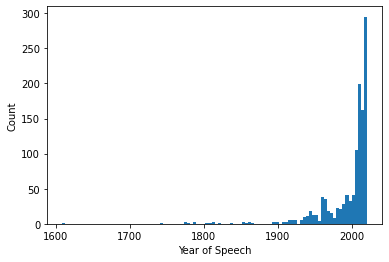

In [0]:
df.year.hist(bins = 100, grid = False)

plt.xlabel("Year of Speech")
plt.ylabel("Count")

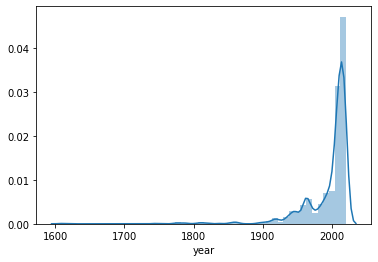

In [0]:
sns.distplot(df.year)

Load pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)

In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased') #uncased is also available

In [0]:
tokens = tokenizer.tokenize(df.summary[0])
# convert tokens into IDs, which will be usef for BERT later on
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {df.summary[0]}')
print(f' Tokens: {tokens}')
print(f' Token_IDs: {token_ids}')

 Sentence:  How privileged I am to be with you here today. And these are the people we need to remember -- not just those in my country, but everywhere else in the world where freedom is yet a dream. To be a whole human being, we need both security and freedom. No doubt, it is not perfect. We have been united, we from many parts of the world, by our belief, by our confidence in democracy. Thank you.
 Tokens: ['How', 'privileged', 'I', 'am', 'to', 'be', 'with', 'you', 'here', 'today', '.', 'And', 'these', 'are', 'the', 'people', 'we', 'need', 'to', 'remember', '-', '-', 'not', 'just', 'those', 'in', 'my', 'country', ',', 'but', 'everywhere', 'else', 'in', 'the', 'world', 'where', 'freedom', 'is', 'yet', 'a', 'dream', '.', 'To', 'be', 'a', 'whole', 'human', 'being', ',', 'we', 'need', 'both', 'security', 'and', 'freedom', '.', 'No', 'doubt', ',', 'it', 'is', 'not', 'perfect', '.', 'We', 'have', 'been', 'united', ',', 'we', 'from', 'many', 'parts', 'of', 'the', 'world', ',', 'by', 'our', 

[Special tokens for BERT](https://huggingface.co/transformers/model_doc/bert.html)

In [0]:
# separation token -- end of sentence mark
tokenizer.sep_token, tokenizer.sep_token_id 

('[SEP]', 102)

In [0]:
# classification token -- add to the start of sentence for BERT to do classification
tokenizer.cls_token, tokenizer.cls_token_id 

('[CLS]', 101)

In [0]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [0]:
# unknown tokens that didn't appear in the training set.
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [0]:
encoding = tokenizer.encode_plus(
    df.summary[0], #sample text
    max_length = 64,
    add_sepcial_tokens = True,  # Add '[CLS]' and '[SEP]'
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt', # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [0]:
print(encoding['input_ids'][0], len(encoding['input_ids'][0]))
print(encoding['attention_mask'][0], len(encoding['attention_mask'][0]))

tensor([  101,  1731, 24758,   146,  1821,  1106,  1129,  1114,  1128,  1303,
         2052,   119,  1262,  1292,  1132,  1103,  1234,  1195,  1444,  1106,
         2676,   118,   118,  1136,  1198,  1343,  1107,  1139,  1583,   117,
         1133,  7244,  1950,  1107,  1103,  1362,  1187,  4438,  1110,  1870,
          170,  4185,   119,  1706,  1129,   170,  2006,  1769,  1217,   117,
         1195,  1444,  1241,  2699,  1105,  4438,   119,  1302,  4095,   117,
         1122,  1110,  1136,   102]) 64


In [0]:
# inverse tokenization
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'How',
 'privileged',
 'I',
 'am',
 'to',
 'be',
 'with',
 'you',
 'here',
 'today',
 '.',
 'And',
 'these',
 'are',
 'the',
 'people',
 'we',
 'need',
 'to',
 'remember',
 '-',
 '-',
 'not',
 'just',
 'those',
 'in',
 'my',
 'country',
 ',',
 'but',
 'everywhere',
 'else',
 'in',
 'the',
 'world',
 'where',
 'freedom',
 'is',
 'yet',
 'a',
 'dream',
 '.',
 'To',
 'be',
 'a',
 'whole',
 'human',
 'being',
 ',',
 'we',
 'need',
 'both',
 'security',
 'and',
 'freedom',
 '.',
 'No',
 'doubt',
 ',',
 'it',
 'is',
 'not',
 '[SEP]']

Choosing Sequence Length for BERT

In [0]:
token_lens = []

# Test with the first speech in the speech data frame
for i, text in enumerate(df.summary):
  # print(i, text)
  tokens = tokenizer.encode(text, max_length = 512)
  token_lens.append(len(tokens))

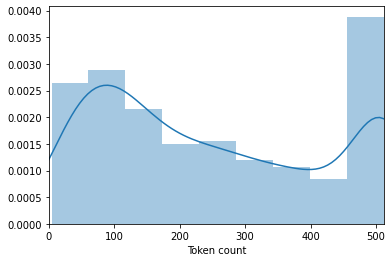

In [0]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 400

Sentiment classification using BERT

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/apps.csv
100% 134k/134k [00:00<00:00, 41.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/gdrive/Shared drives/CS263/data/american_rhetoric/speech_bank/reviews.csv
7.17MB [00:00, 113MB/s]
(14171, 12) (787, 12) (788, 12)
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


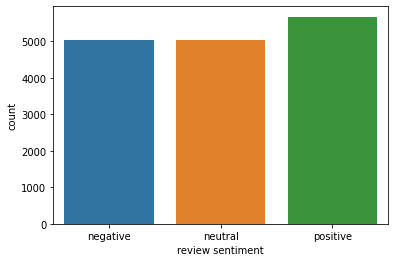

In [0]:
# Google reviews for training the model
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
df = pd.read_csv("reviews.csv")
df.head()
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.unk_token, tokenizer.unk_token_id

MAX_LEN = 160

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

RANDOM_SEED = 0

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(df_train.shape, df_val.shape, df_test.shape)

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [0]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

print(last_hidden_state.shape)

print(bert_model.config.hidden_size)

# pool output, summary of the content
print('pooled output shape:', pooled_output.shape)

# Sentiment classifier using BERT
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

model = SentimentClassifier(len(class_names))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

# softmax(model(input_ids, attention_mask), dim=1)

torch.Size([1, 64, 768])
768
pooled output shape: torch.Size([1, 768])
torch.Size([16, 160])
torch.Size([16, 160])


In [0]:
summary_text = df.summary[0]
# encode the summary text
encoded_summary = tokenizer.encode_plus(
  summary_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [0]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {summary_text}')
print(f'Sentiment  : {class_names[prediction]}')